In [1]:
# For development purposes, reload imported modules when source changes
%load_ext autoreload
%autoreload 2

import spikeextractors as se
import spikewidgets as sw
import spiketoolkit as st
import os, sys

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Create a toy example dataset
recording, sorting_true=se.example_datasets.toy_example1(duration=300, num_channels=4)

In [3]:
# View the filtered timeseries data
filt=st.preprocessing.bandpass_filter(recording,freq_min=300,freq_max=6000)

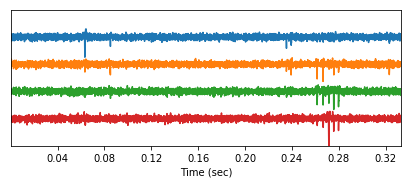

In [4]:
sw.TimeseriesWidget(recording=filt,width=7,height=2.5).display()

In [5]:
traces = filt.getTraces()

In [6]:
# Create a temporary working directory if needed
if not os.path.exists('tmp'): os.mkdir('tmp')

In [15]:
# Mountainsort4 spike sorting
sorting_MS4=st.sorters.mountainsort4(
    recording=recording,
    detect_sign=-1,
    adjacency_radius=-1
)

Using 6 workers.
Using tmpdir: /tmp/tmpcp6gx7d1
Num. workers = 6
Preparing /tmp/tmpcp6gx7d1/timeseries.hdf5...
Preparing neighborhood sorters (M=4, N=9000000)...
Neighboorhood of channel 2 has 4 channels.
Neighboorhood of channel 3 has 4 channels.
Neighboorhood of channel 0 has 4 channels.
Neighboorhood of channel 1 has 4 channels.
Detecting events on channel 1 (phase1)...
Detecting events on channel 3 (phase1)...
Detecting events on channel 2 (phase1)...
Detecting events on channel 4 (phase1)...
Elapsed time for detect on neighborhood: 0:00:00.947243
Num events detected on channel 1 (phase1): 3181
Computing PCA features for channel 1 (phase1)...
Elapsed time for detect on neighborhood: 0:00:00.945945
Num events detected on channel 2 (phase1): 8429
Computing PCA features for channel 2 (phase1)...
Elapsed time for detect on neighborhood: 0:00:00.957852
Num events detected on channel 4 (phase1): 6645
Computing PCA features for channel 4 (phase1)...
Elapsed time for detect on neighborhood

In [12]:
%debug

> /home/alessiob/Documents/Codes/spike_sorting/ml_ms4alg/ml_ms4alg/ms4alg.py(549)prepare_timeseries_hdf5_from_recording()
    547             traces = recording.getTraces(start_frame=s1,end_frame=s2)
    548             print(j, traces.shape, s1, s2, aa, aa+s2-s1, padded_chunk.shape)
--> 549             raise Exception()
    550             padded_chunk[:,aa:aa+s2-s1]=recording.getTraces(start_frame=s1,end_frame=s2) # Read the padded chunk
    551 

ipdb> recording.getTraces(start_frame=s1,end_frame=s2).shape
(4, 1000500)
ipdb> padded_chunk[:,aa:aa+s2-s1].shape
(4, 1000500)
ipdb> padded_chunk[:,aa:aa+s2-s1]=recording.getTraces(start_frame=s1,end_frame=s2)
ipdb> exit


In [ ]:
# SpyKING Circus spike sorting
sorting_SC=st.sorters.spyking_circus(
    recording=recording,
    adjacency_radius=50,
    detect_sign=-1,
    output_folder='tmp',
)

In [ ]:
# KiloSort spike sorting (KILOSORT_PATH and NPY_MATLAB_PATH can be set as environment variables)
sorting_KS=st.sorters.kilosort(
    recording=recording,
    output_folder='tmp',
    kilosort_path='../../KiloSort/',
    npy_matlab_path='../../../npy-matlab/'
)

In [ ]:
# Klusta spike sorting
sorting_KL=st.sorters.klusta(
        recording, # The recording extractor
        output_folder='tmp',
        )

In [ ]:
# IronClust spike sorting (IRONCLUST_PATH can be set as environment variables)
sorting_IC=st.sorters.ironclust(
    recording=recording,
    detect_sign=-1,
    adjacency_radius=-1,
    prm_template_name='tetrode_template.prm',
    ironclust_path='../../ironclust',
    tmpdir='tmp',
)

In [ ]:
# Compute SNRs of true units
snrs=st.postprocessing.computeUnitSNR(recording=recording, sorting=sorting_true, unit_ids=sorting_true.getUnitIds())
sorting_true.setUnitsProperty(property_name='SNR',values=snrs)

In [ ]:
# Comparison MountainSort4 vs truth
comparison_MS4=st.comparison.SortingComparison(sorting_true,sorting_MS4)
sw.SortingAccuracyWidget(sorting_comparison=comparison_MS4, property_name='SNR').plot()

In [ ]:
# Comparison KiloSort vs truth
comparison_KS=st.comparison.SortingComparison(sorting_true,sorting_KS)
sw.SortingAccuracyWidget(sorting_comparison=comparison_KS, property_name='SNR').plot()

In [ ]:
# Comparison SpyKING Circus vs truth
comparison_SC=st.comparison.SortingComparison(sorting_true,sorting_SC)
sw.SortingAccuracyWidget(sorting_comparison=comparison_SC, property_name='SNR').plot()

In [ ]:
# Comparison Klusta vs truth
comparison_KL=st.comparison.SortingComparison(sorting_true,sorting_KL)
sw.SortingAccuracyWidget(sorting_comparison=comparison_KL, property_name='SNR').plot()

In [ ]:
# Comparison IronClust vs truth
comparison_IC=st.comparison.SortingComparison(sorting_true,sorting_IC)
sw.SortingAccuracyWidget(sorting_comparison=comparison_IC, property_name='SNR').plot()

In [ ]:
sw.SortingComparisonTable(comparison_MS4).display()

In [ ]:
sw.SortingComparisonTable(comparison_KS).display()

In [ ]:
sw.SortingComparisonTable(comparison_SC).display()

In [ ]:
sw.SortingComparisonTable(comparison_KL).display()

In [ ]:
sw.SortingComparisonTable(comparison_IC).display()

In [ ]:
comparison_MS4.plotConfusionMatrix()

In [ ]:
# You can use Phy to manually curate the sorting output of any spike sorter
st.postprocessing.exportToPhy(recording, sorting_true, output_folder='ms4')

In [ ]:
!phy template-gui  /home/alessiob/Documents/Codes/spike_sorting/spiketoolkit/examples/ms4/params.py

In [ ]:
sorting_M4_curated = si.PhysortingExtractor('mountainsort/')